In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

In [39]:
!unzip car+evaluation.zip

Archive:  car+evaluation.zip
  inflating: car.c45-names           
  inflating: car.data                
  inflating: car.names               


In [40]:
columns = [
    'buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'
]

df_cars = pd.read_csv('car.data', names=columns)

df_cars.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [41]:
df_cars.shape

(1728, 7)

In [42]:
print("Target distribution:\n")
df_cars['class'].value_counts(dropna=False)

Target distribution:



,count
class,
unacc,1210
acc,384
good,69
vgood,65


**Class Balance Plot**

<ipython-input-43-8ca0e68001dd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_cars, palette='Set2')


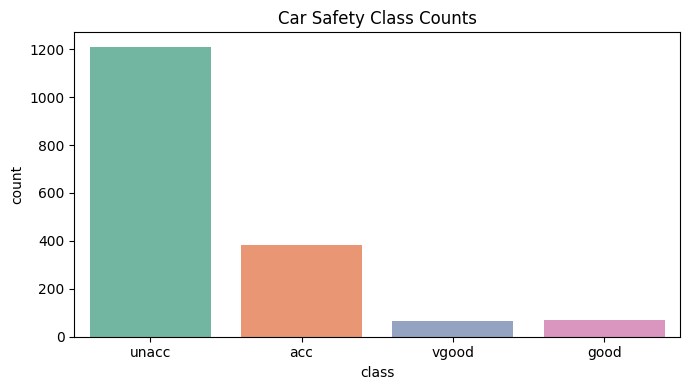

In [43]:
plt.figure(figsize=(7, 4))
sns.countplot(x='class', data=df_cars, palette='Set2')
plt.title('Car Safety Class Counts')
plt.tight_layout()
plt.show()

In [44]:
X_raw = df_cars.drop('class', axis=1)
y      = df_cars['class']

enc = OrdinalEncoder()
X_enc = enc.fit_transform(X_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

In [45]:
def show_metrics(y_true, y_pred, title):
    print(f"\n{title}")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.2f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.2f}")
    print(f"F1-score : {f1_score(y_true, y_pred, average='macro'):.2f}")
    print("\nReport:\n", classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm,
                annot=True, fmt='d',
                cmap='YlGnBu',
                cbar=False,
                xticklabels=enc.categories_[-1],
                yticklabels=enc.categories_[-1])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion matrix — {title}')
    plt.tight_layout()
    plt.show()

**Train Model A - Gini**


Decision Tree – Gini
Accuracy : 0.99
Precision: 0.97
Recall   : 0.96
F1-score : 0.96

Report:
               precision    recall  f1-score   support

         acc      0.950     0.987     0.968        77
        good      0.933     1.000     0.966        14
       unacc      1.000     0.992     0.996       242
       vgood      1.000     0.846     0.917        13

    accuracy                          0.986       346
   macro avg      0.971     0.956     0.962       346
weighted avg      0.986     0.986     0.985       346



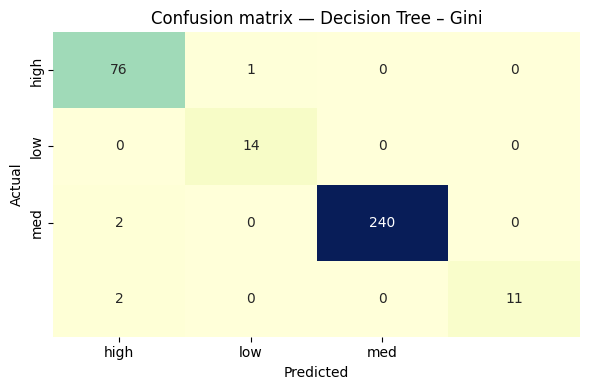

In [46]:
tree_gini = DecisionTreeClassifier(
    criterion='gini',
    random_state=42
)
tree_gini.fit(X_train, y_train)
pred_gini = tree_gini.predict(X_test)

show_metrics(y_test, pred_gini, "Decision Tree – Gini")

**Train Model B - Entropy**


Decision Tree – Entropy
Accuracy : 0.98
Precision: 0.96
Recall   : 0.99
F1-score : 0.97

Report:
               precision    recall  f1-score   support

         acc      0.949     0.974     0.962        77
        good      0.875     1.000     0.933        14
       unacc      1.000     0.983     0.992       242
       vgood      1.000     1.000     1.000        13

    accuracy                          0.983       346
   macro avg      0.956     0.989     0.972       346
weighted avg      0.984     0.983     0.983       346



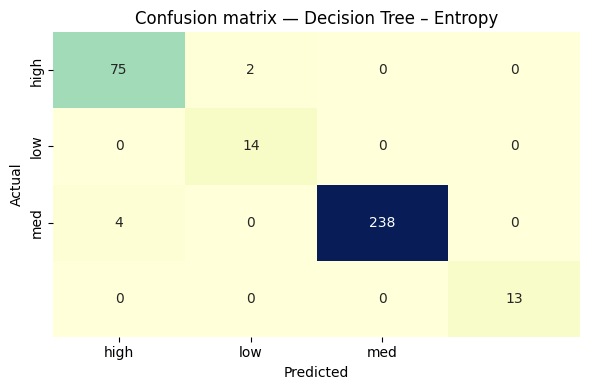

In [47]:
tree_entropy = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

tree_entropy.fit(X_train, y_train)
pred_entropy = tree_entropy.predict(X_test)

show_metrics(y_test, pred_entropy, "Decision Tree – Entropy")

In [48]:
metrics = {
    "Model": ["Gini", "Entropy"],
    "Accuracy": [
        accuracy_score(y_test, pred_gini),
        accuracy_score(y_test, pred_entropy)
    ],
    "Macro-F1": [
        f1_score(y_test, pred_gini, average='macro'),
        f1_score(y_test, pred_entropy, average='macro')
    ]
}

summary_df = pd.DataFrame(metrics)
print("Summary:\n", summary_df.to_string(index=False))

Summary:
   Model  Accuracy  Macro-F1
   Gini  0.985549  0.961547
Entropy  0.982659  0.971635
